In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

**What is a Gated Recurrent Unit (GRU)?**
- A `Gated Recurrent Unit` `(GRU)` is a type of Recurrent Neural Network (RNN) that solves the vanishing gradient problem. It's a simpler and more computationally efficient alternative to the Long Short-Term Memory (LSTM) network. The GRU achieves this by using only two gates: the reset gate and the update gate.

- Reset Gate (r_t): Controls how much of the previous hidden state should be forgotten.

- Update Gate (z_t): Determines how much of the previous hidden state should be carried over to the current hidden state.

- A Simple GRU Example: Time Series Prediction:

This example will demonstrate how a GRU can be used for a simple time series prediction task.

In [4]:
# Generate synthetic time series data
import numpy as np
def generate_time_series_data(num_samples, seq_length):
    import numpy as np
    x = np.linspace(0, 10, num_samples)
    y = np.sin(x) + np.random.normal(0, 0.1, num_samples)

    X, Y = [], []
    for i in range(len(y) - seq_length):
        X.append(y[i:i + seq_length])
        Y.append(y[i + seq_length])

    return np.array(X), np.array(Y)

# Parameters
seq_length = 10
num_samples = 200

# Prepare data
X_raw, Y_raw = generate_time_series_data(num_samples, seq_length)
X_reshaped = X_raw.reshape(X_raw.shape[0], X_raw.shape[1], 1)

# Split data
train_size = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:train_size], X_reshaped[train_size:]
Y_train, Y_test = Y_raw[:train_size], Y_raw[train_size:]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (152, 10, 1)
Testing data shape: (38, 10, 1)


## GRU (Gated Recurrent Unit) Cell Architecture

![GRU Cell Architecture](/content/drive/MyDrive/PrognosAI_OCT25/Notebooks/TheArchitecture-of-the-gated-recurrent-unit-GRU-cell.png)

The GRU cell is a simplified variant of the LSTM cell, designed to address vanishing gradient problems and improve sequence modeling efficiency.

### Main Components

- **Reset gate (\( r_t \))**: Decides how much of the past hidden state (\( h_{t-1} \)) to forget before combining with the current input (\( x_t \)).
- **Update gate (\( z_t \))**: Controls the extent to which the previous hidden state is carried forward to the next time step.
- **Candidate hidden state (\( \hat{h}_t \))**: Generated from the current input and reset-modified hidden state, using the tanh activation function.
- **Final hidden state (\( h_t \))**: A blend of the previous hidden state and the candidate, controlled by the update gate.

### GRU Equations

\[
\begin{align*}
r_t &= \sigma(W_r [h_{t-1}, x_t]) \\
z_t &= \sigma(W_z [h_{t-1}, x_t]) \\
\hat{h}_t &= \tanh(W [r_t * h_{t-1}, x_t]) \\
h_t &= (1 - z_t) * h_{t-1} + z_t * \hat{h}_t
\end{align*}
\]

Where:
- $\sigma$ is the sigmoid activation function,
- $ [h_{t-1}, x_t] $ denotes concatenation of previous hidden state and current input.

The GRU cell’s gating mechanism allows it to retain useful information for long sequences and update its hidden state effectively.


In [15]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

In [16]:
EarlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
ReduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

### Build & Train the model

In [25]:
from typing import ByteString
# Build the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=False, input_shape=(seq_length, 1)))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display model summary
model.summary()

# Train the model
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)
callbacks = [EarlyStopping, ReduceLROnPlateau, model_checkpoint]
best_epoch = np.argmin(history.history['val_loss'])
print (f"Best epoch: {best_epoch}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_7 (GRU)                     │ (None, 50)             │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.3118 - val_loss: 0.3327
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1874 - val_loss: 0.1654
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0907 - val_loss: 0.0506
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0434 - val_loss: 0.0141
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0321 - val_loss: 0.0246
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0393 - val_loss: 0.0211
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0327 - val_loss: 0.0139
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0275 - val_loss: 0.0180
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0279 - val_loss: 0.0234
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0273 - val_loss: 0.0220
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0261 - val_loss: 0.0163
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0276 - val_lo

### Visualize the Result

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


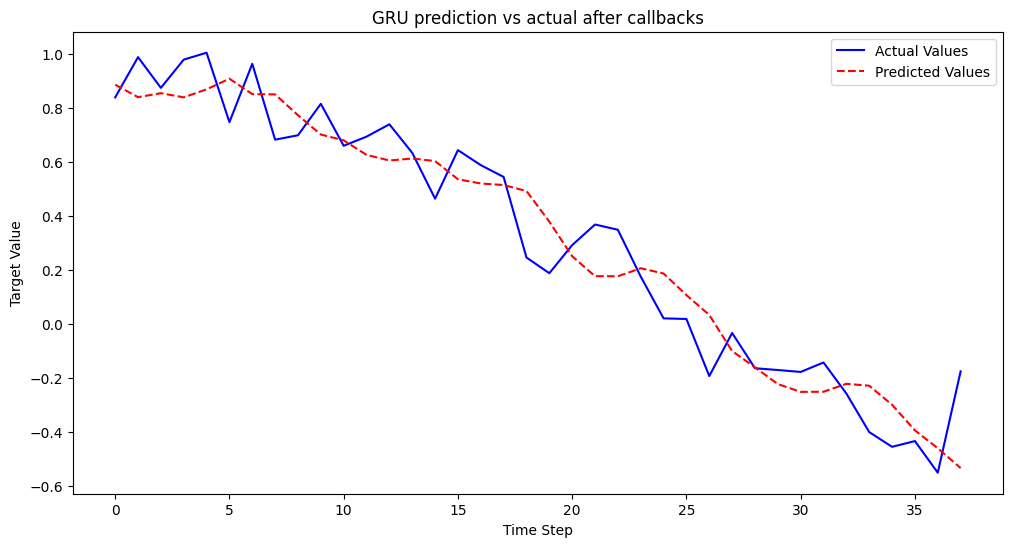

In [23]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(Y_test, label='Actual Values', color='blue')
plt.plot(predictions, label='Predicted Values', color='red', linestyle='dashed')
plt.title(('Time Series Prediction with GRU best model - epoch 6'))
plt.title('GRU prediction vs actual after callbacks')
plt.xlabel('Time Step')
plt.ylabel('Target Value')
plt.legend()
plt.show()

Observations
* In the first graph before the introduction of callbacks the red dash line goes with the trend but doesnt capture the ups and downs like the actual blue line
*After the introduction of the callbacks and printing the best epoch at 6 stopped early for better perfromance.
*The predicted value is smoother than the actual value follows the track of the blue line but in the later stage deviates might be leading to the underfitting
